# Neural Networks For Feature Selection

methodology
>implement pattern-matching algorithm to group data by same piece of information <br>
>see what features to engineer<br>
>What features do we need for the immediacy label?<br>
>See how to deal with those missing values<br>
>feed 5 features at a time to neural network. See the accuracy.<br>

### Target Feature & Its Meaning

IMMEDR="Immediacy with which patient should be seen (unimputed)" => missing values not replaced.

-    -9='Blank'
-    -8='Unknown'
-    0='No triage for this visit but ESA does conduct triage'
-	1='Immediate'
-	2='Emergent'
-	3='Urgent'
-	4='Semi-urgent'
-	5='Nonurgent'
-	7='Visit occurred in ESA that does not conduct nursing triage'

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
NHAMCS = pd.read_sas(filepath_or_buffer = 'NHAMCS.sas7bdat')

In [3]:
NHAMCS.head()

,VMONTH,VDAYR,ARRTIME,WAITTIME,BLANK1,AGE,AGER,AGEDAYS,RESIDNCE,SEX,...,RX30V3C1,RX30V3C2,RX30V3C3,RX30V3C4,SETTYPE,YEAR,CSTRATM,CPSUM,PATWT,EDWT
0,6.0,6.0,b'2056',72.0,NaN,27.0,3.0,-7.0,1.0,2.0,...,NaN,NaN,NaN,NaN,3.0,2017.0,40100000.0,4.0,3723.12641,21.58043
1,6.0,2.0,b'1417',64.0,NaN,1.0,1.0,-7.0,1.0,1.0,...,NaN,NaN,NaN,NaN,3.0,2017.0,40100000.0,4.0,3723.12641,NaN
2,6.0,2.0,b'2303',-7.0,NaN,52.0,4.0,-7.0,1.0,2.0,...,NaN,NaN,NaN,NaN,3.0,2017.0,40100000.0,4.0,3723.12641,NaN
3,6.0,5.0,b'0930',29.0,NaN,5.0,1.0,-7.0,1.0,2.0,...,NaN,NaN,NaN,NaN,3.0,2017.0,40100000.0,4.0,3723.12641,NaN
4,6.0,2.0,b'1332',20.0,NaN,4.0,1.0,-7.0,1.0,1.0,...,NaN,NaN,NaN,NaN,3.0,2017.0,40100000.0,4.0,3723.12641,NaN


In [4]:
NHAMCS.shape

(16709, 949)

### NaNs Exploration

>In this subsection of the data quality section, we explore the following:
- how many NaNs are there?
- how can we visualize them?
- what could be the reasons for these NaNs?
- further steps to be taken for data quality remarks.

### How many NaNs are there?

Count the number of NaNs Across all columns.

In [5]:
nans = NHAMCS.isnull().sum()

Order the series descendingly to be able to see those features with the most NaNs. These will most likely be eliminated from the dataset.

In [6]:
nans.sort_values(ascending = False, inplace = True)

Make sure all the features are captured.

In [7]:
nans.count() 

949

Let's have a quick look...

In [8]:
nans 

RX19V1C4    16709
RX25V1C3    16709
RX25CAT3    16709
RX24V3C4    16709
RX24V3C3    16709
            ...  
RETRNED         0
RETREFFU        0
LWBS            0
LBTC            0
VMONTH          0
Length: 949, dtype: int64

We see that the first entries seem to have ALL NaNs! How prevalent is this? Let's see.

In [9]:
nans_max = nans[nans >= int(0.99*16709)]

In [10]:
nans_max.count()

448

In [11]:
448/949

0.4720758693361433

47% of the features are almost all NaNs! Let's continue to investigate different % of missing values. We exclude the ones with almost all NaNs.

In [12]:
nans_no_max = nans[nans < int(0.99*16709)]

In [13]:
nans_90 = nans_no_max[nans_no_max >= int((0.90*16709))]

In [14]:
print(nans_90.count())
print(104+448, 'features have 90%+ NaNs. That is', 552/949 *100, 'of the features.', 949-448, 'of 949 features have less than 90% NaN.')

104
552 features have 90%+ NaNs. That is 58.16649104320337 of the features. 501 of 949 features have less than 90% NaN.


What about those with 70% NaNs? (excluding the ones with 90%+ NaNs)

In [15]:
nans_70 = nans_no_max[nans_no_max > int((0.7*16709))]
nans_70.count()
print(134+552,'features have 70%+ NaNs. That is', 686/949*100,'of the features.',949-686, 'of 949 features have less than 70%+ NaNs.' )

686 features have 70%+ NaNs. That is 72.28661749209695 of the features. 263 of 949 features have less than 70%+ NaNs.


Some interesting findings. Let's visualize the NaN trend, descendingly.

### NaNs Trend Visualization

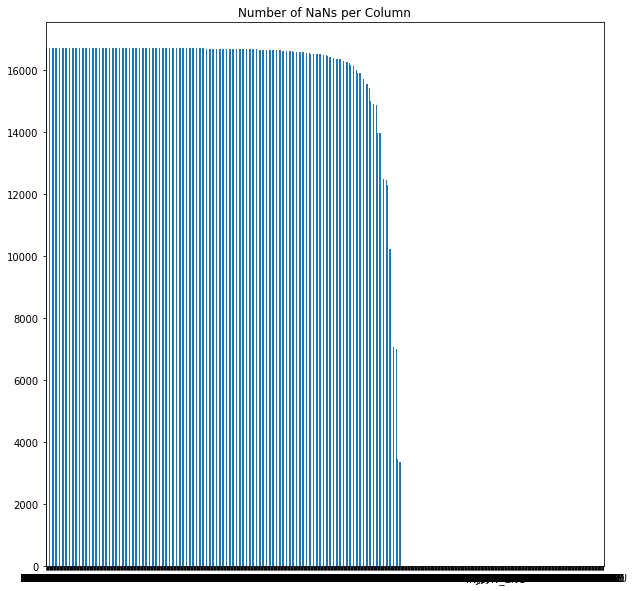

In [16]:
nans.plot(kind = 'bar', figsize = (10,10), title = 'Number of NaNs per Column', xticks = []);

### Why is so much data unavailable?

>From the plot, it seems like we have approximately 550 features whose missing values exceed 80%. Looking at the dataset, this is not exactly surprising. There are four mains reasons. 

#### 1. Information that could have concisely been represented is represented in multiple variables.


>##### EXAMPLE: Payment method. We could use feature engineering to just represent what the source of payment was.
><ol>
    <li>PAYPRIV = "Expected source(s) of payment for this visit: Private insurance"</li>
    <li>PAYMCARE ="Expected source(s) of payment for this visit: Medicare"</li>
    <li>PAYMCAID = "Expected source(s) of payment for this visit: Medicaid or CHIP or other state-based program"</li>
    <li>PAYWKCMP = "Expected source(s) of payment for this visit: Workers' compensation"</li>
    <li>PAYSELF = "Expected source(s) of payment for this visit: Self pay"</li>
    <li>PAYNOCHG = "Expected source(s) of payment for this visit: No charge/Charity"</li>
    <li>PAYOTH = "Expected source(s) of payment for this visit: Other"</li>
    <li>PAYDK = "Expected source(s) of payment for this visit: Unknown"</li>
    <li>PAYTYPER = "Recoded primary expected source of payment for this visit (based on hierarchy)"</li>
</ol>


#### 2. Some features, collectively, are a "list" for the same piece of information.


>##### EXAMPLE: Paitent's medications. Not all pateints are prescribed 30 medicines.
><ol>
    <li>MED1="Medication #1"</li>
    <li>MED2="Medication #2"</li>
    <li>MED3="Medication #3"</li>
    <li>MED4="Medication #4"</li>
    <li>...</li>
    <li>MED27="Medication #27"</li>
    <li>MED28="Medication #28"</li>
    <li>MED29="Medication #29"</li>
    <li>MED30="Medication #30"</li>
</ol>

#### 3. With or without reason 2, a collection of features represent a level of detail for the same information.

>##### EXAMPLE: Paitent's complaints. Along with the listing, there is a "level of detail" to the complaint.
><ol>
    <li>RFV1 = "Patient's complaint, symptom, or other reason for visit #1 - detailed category"</li>
    <li>RFV1 = "Patient's complaint, symptom, or other reason for visit #2 - detailed category"</li>
    <li>RFV1 = "Patient's complaint, symptom, or other reason for visit #3 - detailed category"</li>
    <li>RFV1 = "Patient's complaint, symptom, or other reason for visit #4 - detailed category"</li>
    <li>RFV1 = "Patient's complaint, symptom, or other reason for visit #5 - detailed category"</li>
    <li>...</li>
    <li>RFV13D = "Patient's complaint, symptom, or other reason for visit #1 - detailed category"</li>
    <li>RFV13D = "Patient's complaint, symptom, or other reason for visit #2 - detailed category"</li>
    <li>RFV13D = "Patient's complaint, symptom, or other reason for visit #3 - detailed category"</li>
    <li>RFV13D = "Patient's complaint, symptom, or other reason for visit #4 - detailed category"</li>
    <li>RFV13D = "Patient's complaint, symptom, or other reason for visit #5 - detailed category"</li>
</ol>


#### 4. There are features that are reserved for only special pateints. 

>##### EXAMPLE: 'AGEDAYS' - age days for babies. This could be missing for the rest of the sample.
><ol>
    <li>AGE="Patient age in years"</li>
    <li>AGER="Age recode"</li>
    <li>AGEDAYS="Age in days for patients less than one year"</li>
</ol>




#### What are some key takeaways from these observations?

- All the reasons portray how well-suited this dataset is for a myriad of specific use cases and research, albeit with challenging and elongated data cleaning procedures. 

- Reasons 1 to 3 Feature engineering may also be used extensively to extract the essence of the required data for the problem at hand.

- Reason 4 unleashes an extremely important fact: Do not assume that, if 95% of a column's values are missing, that we could safely drop it. It might be catered for a specific use case and hence missing for the majority. For example, if the use case is to study which diseases result in ER visits for babies the most, although this feature could be mostly missing, it is actually important and the missing % is misleading.

- All reasons show us that we might not necessarily need to drop a column with high % of NaNs. From the special features of the available subset along with some domain research, we might be able to replace the missing data accurately.

### Further Comments and Prospective Steps

#### Missing Values Further Steps
- Investigate for also these values: [-9, -8, -7, 0]. -9 always means missing values, so we deal with that as such. However, -8 means "unknown" and -7 means "N/A". 0 may also mean "blank." For features extracted, according to the nature of each feature, we must decide what to do with entries with those values. Some examples include the below.

		
>**1. VALUE RESIDF**<br>
  >  -9='Blank'<br>
   > -8='Unknown'<br>
	1='Private residence'<br>
	2='Nursing home'<br>
	3='Homeless/homeless shelter'<br>
	4='Other'<br>
    
>**2. VALUE WAITTIMEF**<br>
    -9 ='Blank'<br>
    -7 ='Not Applicable'<br>
    
>**3. VALUE PAYTYPERF**<br>
      -9 ='All sources of payment are blank'<br>
      -8 ='Unknown'<br>
       1 ='Private insurance'<br>
       2 ='Medicare'<br>
       3 ='Medicaid or CHIP or other state-based program'<br>
       4 ="Worker's compensation"<br>
       5 ='Self-pay'<br>
       6 ='No charge/Charity'<br>
       7 ='Other'   <br>
 


<br>


- for the extracted features, based on the problem domain, available data %, and relationships with other features, how can we best replace those missing values? Extensive research is needed.


#### Data Quality Concerns For Further Investigation
- are the values consistent?
- are the types suitable?
- is te data too granular or too specific for a use case?
- is the data comprehensive for a use case?
- invesigate the data collection time and determine its relevance for today.
- is the data precise?
- are the features selected complete?



### Extracting Patterns

#### HELPER: Function to Extract the Prefixes

In [41]:
temp = NHAMCS[['RACEUN','RACER','RACERETH','NOPAY']]

In [62]:
#TESTS PASSED

#n is the length of the prefix
#df is the dataframe
def extract_prefixes(n, df):
    l = []
    for col in df.columns:
        l.append((col[:n]))
    return l

#### HELPER: Find the Longest Prefix

In [63]:
#TESTS PASSED 
def longest_prefix(df):
    l = []
    for col in df.columns:
        l.append(len(col))
    return max(l)

In [64]:
longest_prefix(NHAMCS)

12

This means we stop prefixing at 12.

#### Find Prefix frequency per Prefix Length 

In [70]:
from collections import Counter
unordered_list = extract_prefixes(3,NHAMCS)
counter=Counter(unordered_list)
#result = [list(counter.keys()),list(counter.values())]
print(counter)

Counter({'RX1': 176, 'RX2': 176, 'RX3': 32, 'PRE': 31, 'MED': 31, 'CON': 31, 'GPM': 30, 'DRU': 30, 'COM': 30, 'RX4': 16, 'RX5': 16, 'RX6': 16, 'RX7': 16, 'RX8': 16, 'RX9': 16, 'RFV': 10, 'PAY': 9, 'DIA': 9, 'OBS': 8, 'OTH': 7, 'PTO': 6, 'BLA': 5, 'PRD': 5, 'HDD': 5, 'AGE': 4, 'RES': 4, 'RAC': 4, 'INJ': 4, 'TOT': 4, 'ADM': 4, 'ESU': 4, 'EDI': 4, 'ETH': 3, 'CAU': 3, 'INC': 3, 'NUM': 3, 'TRA': 3, 'EME': 3, 'ESH': 3, 'EED': 3, 'BED': 3, 'ARR': 2, 'SEX': 2, 'AMB': 2, 'NOP': 2, 'TEM': 2, 'PUL': 2, 'BPS': 2, 'BPD': 2, 'CAR': 2, 'URI': 2, 'CAT': 2, 'CTC': 2, 'MRI': 2, 'PHY': 2, 'RET': 2, 'PAT': 2, 'ERE': 2, 'ECO': 2, 'EDP': 2, 'BOA': 2, 'REG': 2, 'HLI': 2, 'VMO': 1, 'VDA': 1, 'WAI': 1, 'POP': 1, 'IMM': 1, 'PAI': 1, 'SEE': 1, 'EPI': 1, 'INT': 1, 'ETO': 1, 'ALZ': 1, 'AST': 1, 'CAN': 1, 'CEB': 1, 'CKD': 1, 'COP': 1, 'CHF': 1, 'CAD': 1, 'DEP': 1, 'ESR': 1, 'HPE': 1, 'EDH': 1, 'HYP': 1, 'HTN': 1, 'OBE': 1, 'OSA': 1, 'OST': 1, 'SUB': 1, 'NOC': 1, 'ABG': 1, 'BAC': 1, 'BMP': 1, 'BNP': 1, 'BUN': 1, 'CB

#### Return Features with the Same Prefix

In [65]:
def pattern_match(prefix, df):
    l = []
    for col in df.columns:
        if(col.startswith(prefix)):
            l.append(col)
    return l

### Step 1: extract all possible prefixes.

In [66]:
for i in [2,3,4,5,6,7,8,9,10,11]:
    print('For', i, '-length prefixes, there are:')
    print(extract_prefixes(i,NHAMCS))
    print('------------------------------------------------------------------------------------------------------------')
    print()
    print()
    

For 2 -length prefixes, there are:
['VM', 'VD', 'AR', 'WA', 'BL', 'AG', 'AG', 'AG', 'RE', 'SE', 'ET', 'ET', 'RA', 'RA', 'RA', 'AR', 'AM', 'NO', 'PA', 'PA', 'PA', 'PA', 'PA', 'PA', 'PA', 'PA', 'PA', 'TE', 'PU', 'RE', 'BP', 'BP', 'PO', 'IM', 'PA', 'SE', 'RF', 'RF', 'RF', 'RF', 'RF', 'RF', 'RF', 'RF', 'RF', 'RF', 'EP', 'IN', 'IN', 'IN', 'IN', 'IN', 'CA', 'CA', 'CA', 'DI', 'DI', 'DI', 'DI', 'DI', 'PR', 'PR', 'PR', 'PR', 'PR', 'ET', 'AL', 'AS', 'CA', 'CE', 'CK', 'CO', 'CH', 'CA', 'DE', 'DI', 'DI', 'DI', 'ES', 'HP', 'ED', 'HY', 'HT', 'OB', 'OS', 'OS', 'SU', 'NO', 'TO', 'DI', 'AB', 'BA', 'BM', 'BN', 'BU', 'CA', 'CB', 'CM', 'BL', 'TR', 'UR', 'WO', 'OT', 'DD', 'EL', 'GL', 'LA', 'LF', 'PT', 'OT', 'CA', 'EK', 'HI', 'FL', 'PR', 'TO', 'UR', 'OT', 'AN', 'XR', 'CA', 'CT', 'CT', 'CT', 'CT', 'CT', 'CT', 'MR', 'MR', 'UL', 'OT', 'TO', 'PR', 'BP', 'BL', 'CA', 'CE', 'CP', 'EN', 'IN', 'IV', 'LU', 'NE', 'PE', 'SK', 'SU', 'OT', 'TO', 'ME', 'ME', 'ME', 'ME', 'ME', 'ME', 'ME', 'ME', 'ME', 'ME', 'ME', 'ME', 'ME'